In [1]:
from boot_utes import (reload, add_path, path, run_magics)
add_path('..', '../src/', '~/repos/myutils/', )

from src.crash_imps import *; exec(pu.DFCols_str); exec(pu.qexpr_str); run_magics()
# import utils.en_utils as eu; import data.load_data as ld; exec(eu.sort_dfs_str)

sns.set_style('whitegrid')


# A.data_transformers.enable('json', prefix='../data/altair-data')
A.data_transformers.enable('default')

S = Series; D = DataFrame

from big_query import bq_read

import warnings
from matplotlib import MatplotlibDeprecationWarning

from joblib import Memory

mem = Memory(location="cache", verbose=0)

import altair.vegalite.v3 as A
import requests
pd.options.display.max_rows = 100
pd.options.display.min_rows = 40

Automatic calling is: Smart


In [2]:
import pystan
import models.stan_mods as sm

# Load

In [3]:
import covid_scrape as cvs
from covid_scrape import add_point, add_line, A
from covid_scrape import lgs, pl
import model_transformations as mtx

data_dir = Path('../data')
load_states = mem.cache(cvs.load_states)

In [4]:
# cvs.pull_and_save_ga_county()
# cvs.pull_and_save_ga_agg()
dfct = cvs.load_ga_county()
ga_agg = cvs.load_ga_agg()

In [7]:
date_arg = '03-29'
fn_date = '0329'
dfs = (
    load_states(date=date_arg)
    .sort_values(["state", "date"], ascending=True)
    .reset_index(drop=1)
)
print(f"Max date {dfs.date.max()}")
dfs = cvs.process_state(dfs)
print(f"Current actual max date: {cvs.load_states().date.max()}")

Max date 20200329
Current actual max date: 20200329


# Models

## Mortality model

In [35]:
# import pystan

def log_preds(df):
    preds = [c for c in df if c.startswith('pred_')]
    df = df.assign(**{pred: lambda x, pred=pred: np.exp(x[pred]) for pred in preds})
    return df

dfd = cvs.filter_mortality(dfs)

dfd = (
    dfd.assign(
        ldeaths=lambda x: x.death.pipe(np.log),
        daysi=lambda x: (x.date - x.date.min()).astype('timedelta64[D]').astype(int)
    )
    .reset_index(drop=1)
    .drop(["dateChecked", 'pending'], axis=1)
)

[min_date] = dfd.query("daysi == 0").date

def dayi2date(i):
    return min_date + pd.Timedelta(days=i)

## Data for predictions

In [9]:
dfsim1_ = mtx.mk_sim_df1(dfd).assign(date=lambda x: x.daysi.map(dayi2date))

In [10]:
# Write to R; generate simulations
dfd_wk = dfd.pipe(lambda x: x[x.date >= x.date.max() - pd.Timedelta(days=7)]).reset_index(drop=1)
dfd_wk.to_feather(data_dir / f'mort_{fn_date}.fth')
dfsim1_.to_feather(data_dir / f'mort_sim_{fn_date}.fth')

## Model v1

In [11]:
# Read end result
# dfsim_out = pd.read_feather(data_dir / 'mort_0320_sim_out.fth')
dfsim_preds = pd.read_feather(data_dir / 'mort_preds_0328.fth')
# dfsim1 = dfsim1_.merge(dfsim_out, on='row').pipe(log_preds)

In [37]:
dfsim_preds = pd.read_feather(data_dir / "mort_preds_0328.fth").rename(
    columns={"pred_state": "state", "pred_daysi": "daysi"}
)
dfsim2_preds = (
    dfsim1_.merge(dfsim_preds, on=["state", "daysi"])
    .pipe(log_preds)
    .assign(date=lambda x: x.daysi.map(dayi2date))
)

#### Plot Results

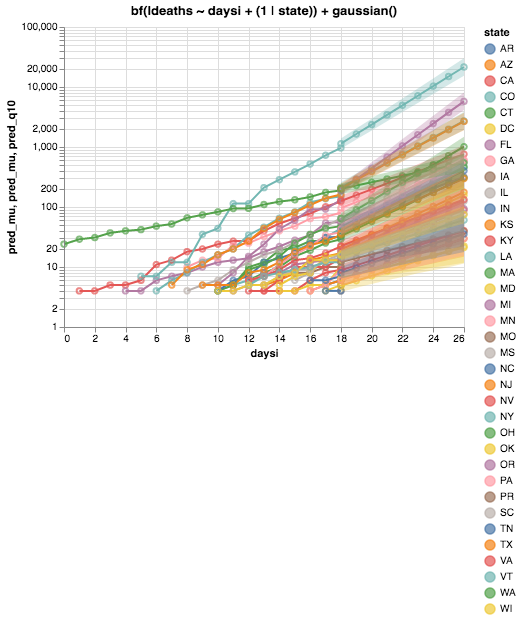

In [39]:
color = "state"
x = "daysi"
y = "pred_mu"


pred = dfsim2_preds
actual = dfd.assign(pred_mu=lambda x: x["death"])


def deco(ch):
    h = ch.mark_line().encode(
        x=A.X(x, title=x),
        y=A.Y(y, title=y, scale=lgs),
        color=color,
        tooltip=[color, x, y],
    )
    return h


h_act = deco(Chart(actual))
h_est = deco(Chart(pred))
h_est_err = h_est.mark_errorband().encode(
    y="pred_q10", y2="pred_q90", x="daysi", color=color,
)

ch_act = h_act + h_act.mark_point()
ch_est = h_est + h_est.mark_point() + h_est_err


form1 = "bf(ldeaths ~ daysi + (1 | state)) + gaussian()"
save_ch = (ch_act + ch_est).properties(title=form1)
save_ch

In [51]:
# m1_path = Path('covid/models/mortal/v1')
# write_model(m1_path, dfsim1, "bf(ldeaths ~ daysi + (1 | state)) + gaussian()", save_ch)

## Model v2

### Coefs

In [ ]:
# Estimate doubling rate below with rule of 72. Exponent for WA is about .05, so doubling rate is about 72 / 5 = 14.4 days. This gets less accurate (but still high) for higher coefficient states like NY.

In [40]:
WA = .05
def doubling_time(ex):
    return 1 / ex * np.log(2)

doubling_time(.17)

4.077336356234972

In [41]:
fn_spread = data_dir / "mort_draws.fth"

In [43]:
draws = pd.read_feather(fn_spread)
growth_dbl = (
    draws.query("coef == 'daysi'")
    .assign(coef=lambda x: x.b_daysi + x.r_state)
    .assign(doubling_time=lambda x: doubling_time(x.coef))
    .groupby(["state"])
    .doubling_time.quantile([0.05, 0.5, 0.95])
    .unstack()
    .fillna(0)
    .rename(columns=lambda x: "p{:02}".format(int(x * 100)))
    .reset_index(drop=0)
    .sort_values("p05", ascending=True)
    .reset_index(drop=1)
)

Doubling rate: if the value is around 2, then expect the number of deaths to double every 2 days.

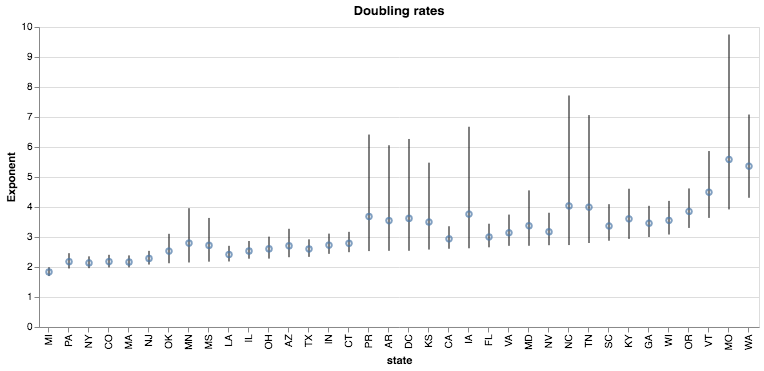

In [44]:
color = 'dvers'
x = 'state'
y = 'p50'

h = Chart(growth_dbl).mark_point().encode(
    x=A.X(x, title=x, sort=None),
    y=A.Y(y, title='Exponent'),
    tooltip=[x, y]
)

herr = h.mark_errorbar().encode(y=A.Y('p05', title='Exponent'), y2='p95')
# (h + h.mark_point()).interactive()
(herr + h).properties(title='Doubling rates')

In [85]:
# xs = np.arange(100)
# yx = np.exp(xs * .1)

# expdf = DataFrame(dict(x=xs, y=yx))
# ixs = np.searchsorted(expdf.y, [1, 2, 4, 8, 16])
# expdf.iloc[ixs].x.pipe(lambda x: x - x.shift(1))
# plt.plot(xs, yx)

### Load simulated data

#### 03-27
Exponential growth in NYC is tapering off, but estimate takes previous 7 days of data, so it's still estimating high growth.

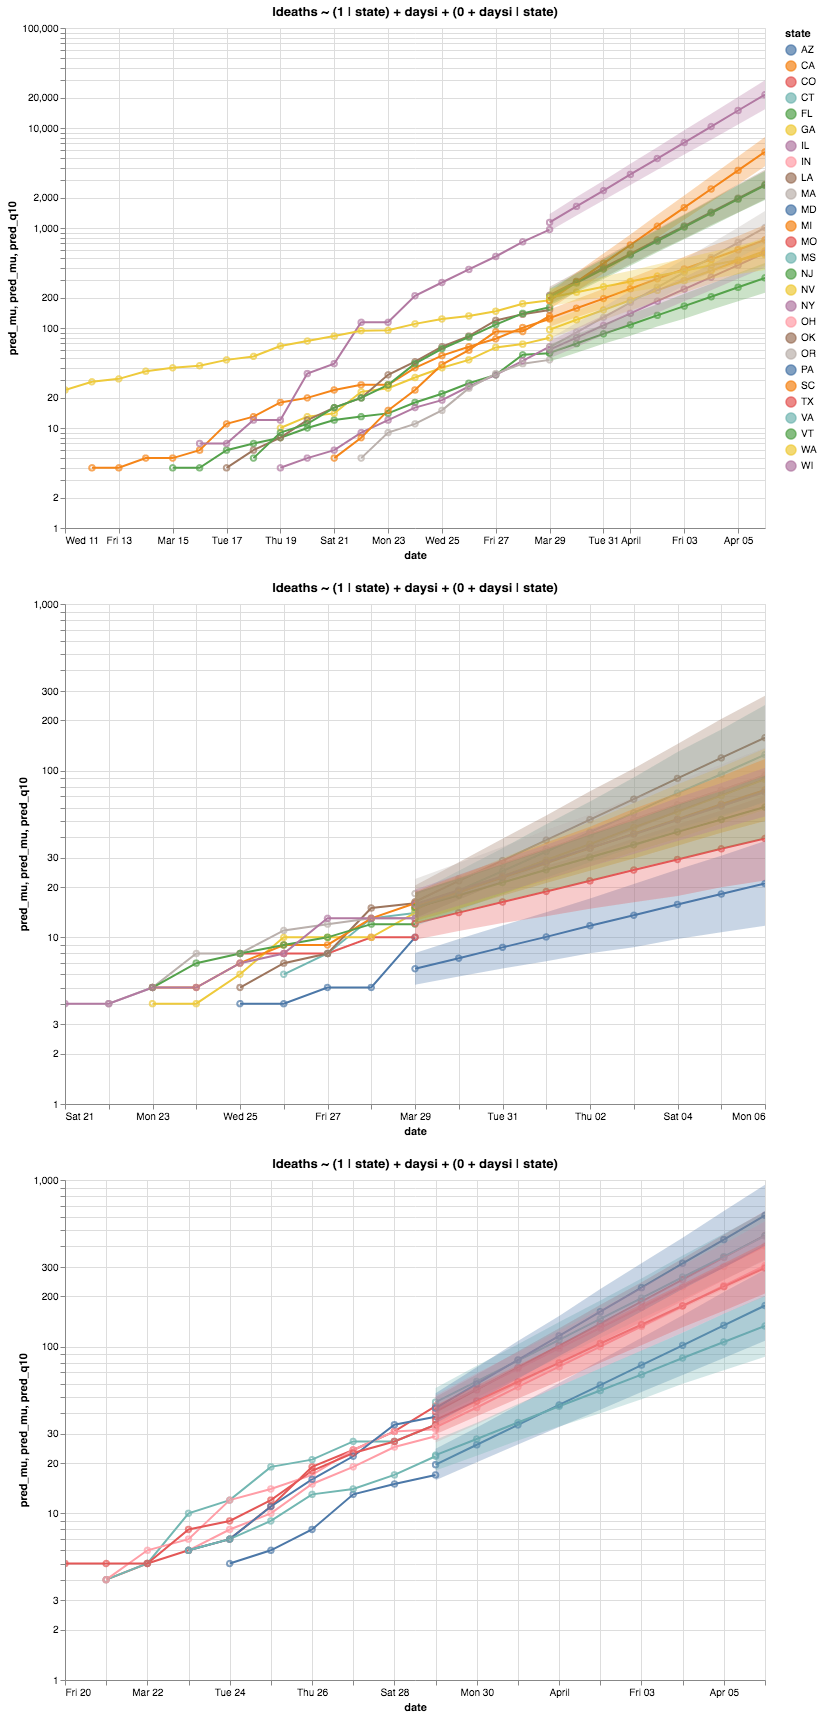

In [45]:
def plot_preds_act(pred, actual, form, x = "daysi", log=True, keep_group=None):
    color = "state"
    yargs = {}
    if log:
        yargs['scale'] = lgs
    y = "pred_mu"

    state_mapping = cvs.clf_states_mapping(actual, topn=10)
    actual = actual.assign(pred_mu=lambda x: x["death"], state_group=lambda x: x.state.map(state_mapping))
    pred = pred.assign(state_group=lambda x: x.state.map(state_mapping))
    
    if keep_group is not None:
        actual = actual.query("state_group == @keep_group")
        pred = pred.query("state_group == @keep_group")

    def deco(ch):
        h = ch.mark_line().encode(
            x=A.X(x, title=x),
            y=A.Y(y, title=y, **yargs),
            color=color,
            tooltip=[color, x, y],
        )
        return h

    h_act = deco(Chart(actual))
    h_est = deco(Chart(pred))
    h_est_err = h_est.mark_errorband().encode(
        y="pred_q10", y2="pred_q90", x=x, color=color
    )

    ch_act = h_act + h_act.mark_point()
    ch_est = h_est + h_est.mark_point() + h_est_err
#     return ch_est
    save_ch = (ch_act + ch_est).properties(title=form, height=500, width=700)
    return save_ch.interactive()


states_low_deaths = dfd.groupby('state').death.max().pipe(lambda x: x[x < 10]).index.tolist()

# bf(ldeaths ~ (1 | state) + daysi + (0 + daysi | state))
form2 = "ldeaths ~ (1 | state) + daysi + (0 + daysi | state)"

pdfsim = dfsim2_preds.query("state not in @states_low_deaths")
pdfd = dfd.query("state not in @states_low_deaths")

# m2pl_lin = plot_preds_act(pred=pdfsim, actual=pdfd, form=form2, x='date', log=0).properties(width=900, height=600)
m2pl_log = plot_preds_act(pred=pdfsim, actual=pdfd, form=form2, x='date', log=1).properties(width=900, height=600)

# with A.data_transformers.enable('default'):
#     A.Chart.save(m2pl_lin, '../fig/m2_pred_lin_0324.png')

# with A.data_transformers.enable('default'):
#     A.Chart.save(m2pl_log, '../fig/m2_pred_log_0324.png')

_ch0 = plot_preds_act(pred=pdfsim, actual=pdfd, form=form2, x='date', log=1, keep_group=0)
_ch1 = plot_preds_act(pred=pdfsim, actual=pdfd, form=form2, x='date', log=1, keep_group=1)
_ch2 = plot_preds_act(pred=pdfsim, actual=pdfd, form=form2, x='date', log=1, keep_group=2)
(_ch0 & _ch1 & _ch2)

In [46]:
jupyter = "/Users/wbeard/miniconda3/envs/avast/bin/jupyter"
res = !"$jupyter" nbconvert --to html --template nbconvert_template_altair.tpl covid_model.ipynb
!cp covid_model.html ../index.html

# Log and Linear -- old

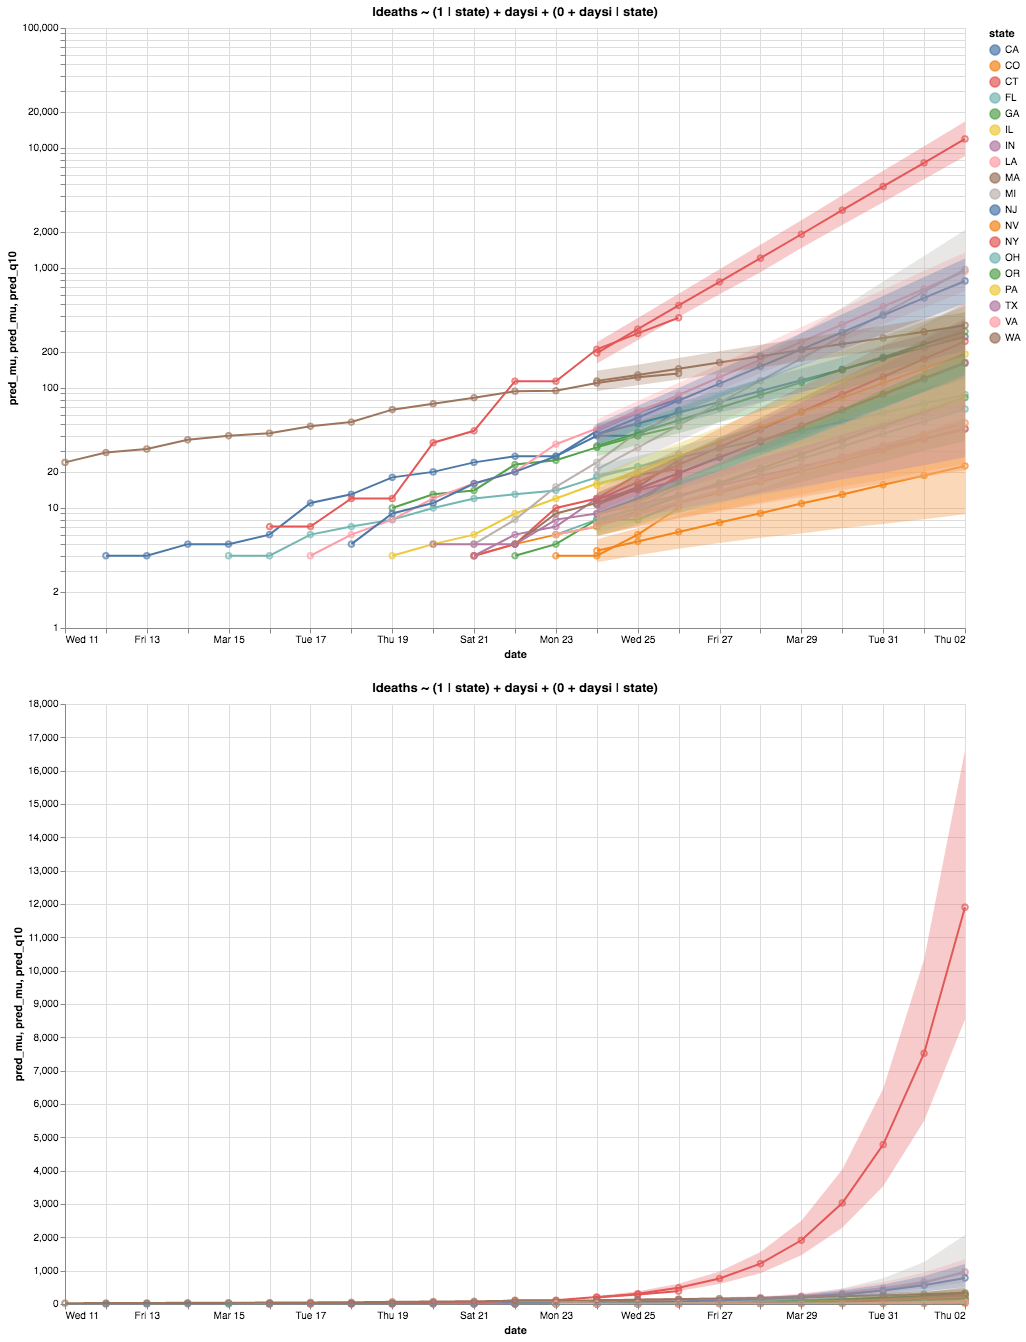

In [204]:
m2pl_log & m2pl_lin

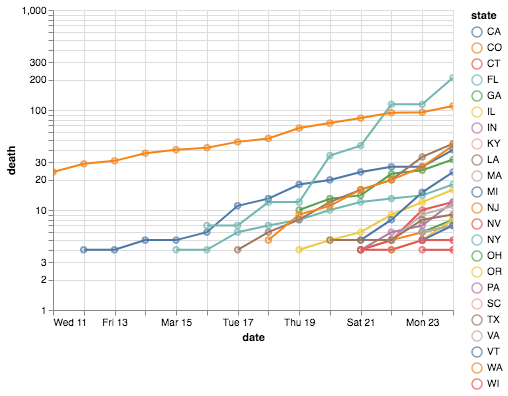

In [17]:
p2 = pl(dfd, x='date', y='death')
p2

# Deaths ~ delayed infection

## Model: autoregressive model of prob by state

In [205]:
# Delayed df w/ state data
# 4 days w/ recorded deaths
ddfs = cvs.filter_mortality(dfs, days_previous=4, min_death_days=4)

In [206]:
ddelayed[:3]

,state,date,death,total,positive,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed,pdel05,pdel50,pdel95,bdeath05,bdeath50,bdeath95
0,CA,2020-03-16,6,8316,335,202,1118,0.180680,0.18068,0.162430,0.180470,0.198680,-24.490267,-19.624478,-15.846227
1,CA,2020-03-17,11,8407,483,202,1118,0.180680,0.18068,0.162692,0.180646,0.199166,-19.670645,-15.967169,-13.076747
2,CA,2020-03-18,13,8592,611,252,1168,0.215753,0.18068,0.193777,0.212798,0.232344,-16.715913,-13.816589,-11.457396


In [207]:
mod = ms.compile('../models/mortal2.stan')

./cached-mortal2-656d76c58e7a7812b02e46879d3c8c1f.pkl
loading...
Using cached StanModel


In [20]:
ddfs.query("pos_delayed > 0")[:3]

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,perc,dupe_neg,n_pct_rows,tot,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed
98,2020-03-16,CA,335.0,7981.0,NaN,NaN,6.0,8316,2020-03-16T20:00:00Z,0.040284,False,21,8316.0,202.0,1118.0,0.180680,0.18068
99,2020-03-17,CA,483.0,7981.0,NaN,NaN,11.0,8407,2020-03-17T20:00:00Z,0.057065,True,21,8464.0,202.0,1118.0,0.180680,0.18068
100,2020-03-18,CA,611.0,7981.0,NaN,NaN,13.0,8592,2020-03-18T20:00:00Z,0.071113,True,21,8592.0,252.0,1168.0,0.215753,0.18068


In [10]:
ddelayed = sm.Mpv1.preprocess_data(ddfs)
data = sm.Mpv1.mk_data(ddelayed)
# data = mk_data(ddelayed)
res = mod.sampling(data=data)

In [11]:
def update_perc_est(ddelayed, res):
    par_est = ms.extract_arrs(res, pars=['p_delay'])['p_delay'].quantile([.05, .5, .95])
    ddelayed['pdel05'] = par_est.loc[.05].values
    ddelayed['pdel50'] = par_est.loc[.5].values
    ddelayed['pdel95'] = par_est.loc[.95].values
    return ddelayed

ddelayed = update_perc_est(ddelayed, res)

In [12]:
ddelayed[:3]

,state,date,death,total,positive,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed,pdel05,pdel50,pdel95
0,CA,2020-03-16,6,8316,335,202,1118,0.180680,0.18068,0.163406,0.180951,0.199064
1,CA,2020-03-17,11,8407,483,202,1118,0.180680,0.18068,0.163224,0.180933,0.199426
2,CA,2020-03-18,13,8592,611,252,1168,0.215753,0.18068,0.195514,0.213884,0.232726


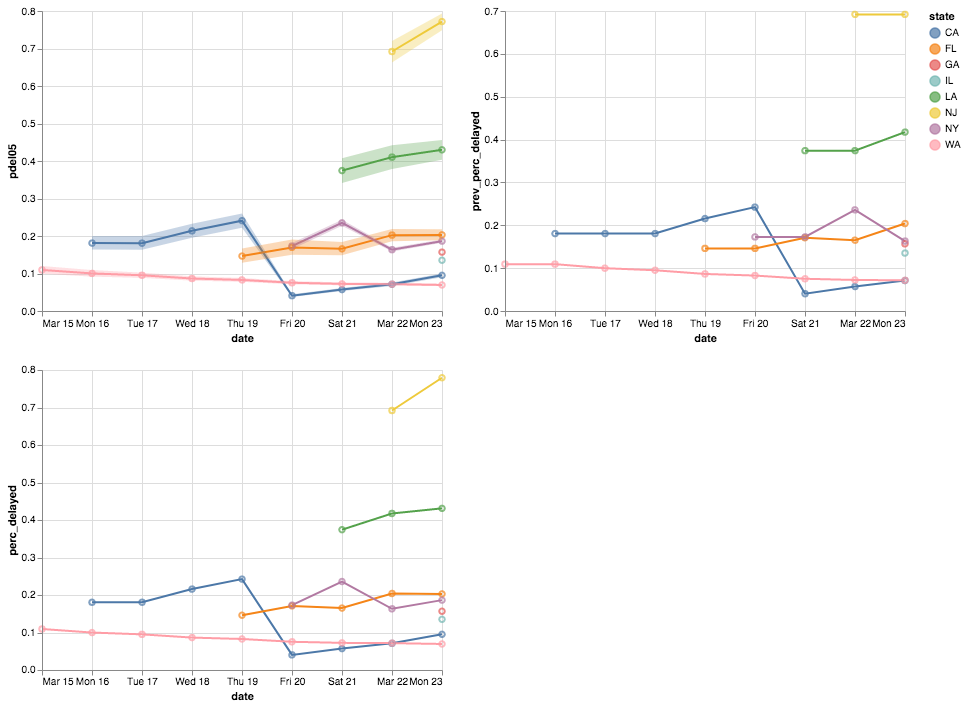

In [202]:
color = 'state'
x = 'date'
# y = 'pdel50'
y = 'perc_delayed'

pdf = ddelayed

h = Chart(pdf).mark_line().encode(
    x=A.X(x, title=x),
    y=A.Y(y, title=y),
    color=color,
    tooltip=[color, x, y]
)

h2 = h.encode(y=c.prev_perc_delayed, tooltip=[color, x, y, c.prev_perc_delayed])
h2 = (h2 + h2.mark_point())

h3 = h.encode(y=c.pdel50, tooltip=[color, x, y, c.pdel50])
h3 = (h3 + h3.mark_point())

r1 = h3 + h.mark_errorband().encode(y='pdel05', y2='pdel95') | h2
r2 = (h + h.mark_point())
r1 & r2

## Autoregressive delayed infection rate

In [208]:
ddfs = cvs.filter_mortality(dfs, days_previous=4, min_death_days=4)

In [209]:
mod = ms.compile('../models/mortal_delay.stan')

./cached-mortal_delay-ba0f1d0696c6e2d17bb10e912c857d28.pkl
loading...
Using cached StanModel


In [210]:
def mk_data(df):
    data = dict(
        N=len(df),
        # S=df.state.nunique(),
        npos_delayed=df.pos_delayed,
        ntot_delayed=df.tot_delayed,
        perc_delayed=df.perc_delayed,
        perc_delayed_prev=df.prev_perc_delayed,
        
        n_deaths=df.death,
        p_death_baseline=df.prev_perc_delayed,
    )
    return data

_ints = ["death", "total", "positive", "pos_delayed", "tot_delayed"]
_fs = "perc_delayed prev_perc_delayed ".split()
ddelayed = (
    ddfs[["state", "date"] + _ints + _fs]
    .query("pos_delayed > 0")
    .query("prev_perc_delayed > 0")
    .assign(**{icol: lambda x, icol=icol: x[icol].astype(int) for icol in _ints})
    .reset_index(drop=1)
)
data = mk_data(ddelayed)

In [215]:
res = mod.sampling(data=data)
par_p_delay = ms.extract_arrs(res, pars='p_delay')['p_delay']

In [59]:
# data['perc_delayed']

In [211]:
def update_perc_est(ddelayed, res, parname='p_delay', pref='pdel'):
    fmt = "{:02d}".format
    qs = [.05, .5, .95]
    par_est = ms.extract_arrs(res, pars=[parname])[parname].quantile(qs)
    for q in qs:
        ddelayed[pref + fmt(int(q * 100))] = par_est.loc[q].values
    
#     ddelayed['pdel05'] = par_est.loc[.05].values
#     ddelayed['pdel50'] = par_est.loc[.5].values
#     ddelayed['pdel95'] = par_est.loc[.95].values
    return ddelayed

In [214]:
ddelayed.date.max()

Timestamp('2020-03-26 00:00:00')

In [216]:
ddelayed = update_perc_est(ddelayed, res)
ddelayed = update_perc_est(ddelayed, res, parname='b_death', pref='bdeath')

In [217]:
ddelayed[:3]

,state,date,death,total,positive,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed,pdel05,pdel50,pdel95,bdeath05,bdeath50,bdeath95
0,CA,2020-03-16,6,8316,335,202,1118,0.180680,0.18068,0.162762,0.180218,0.198099,-24.412156,-19.602836,-15.848505
1,CA,2020-03-17,11,8464,483,202,1118,0.180680,0.18068,0.162968,0.180530,0.198485,-19.693981,-15.936273,-13.048595
2,CA,2020-03-18,13,8592,611,252,1168,0.215753,0.18068,0.195199,0.213293,0.233194,-16.485429,-13.765098,-11.496808


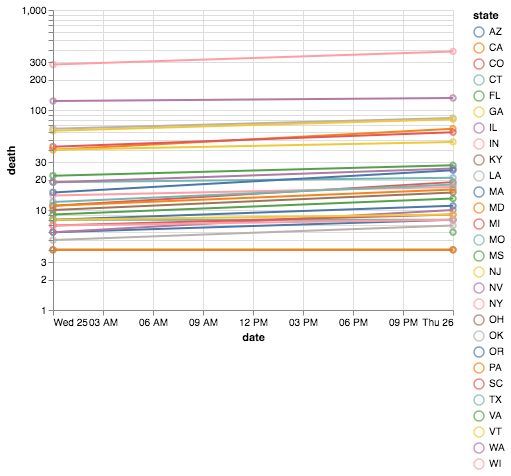

In [219]:
h.pipe(add_point)

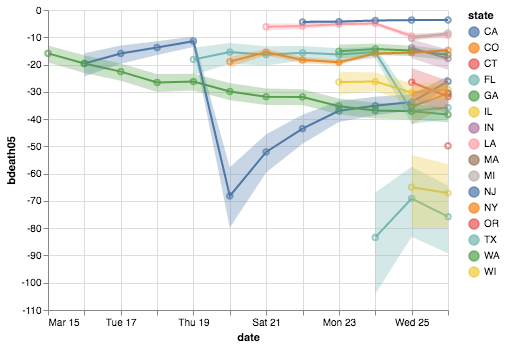

In [220]:
color = 'state'
x = 'date'
# y = 'pdel50'
y = 'perc_delayed'

pdf = ddelayed

h = Chart(pdf).mark_line().encode(
    x=A.X(x, title=x),
    y=A.Y(y, title=y),
    color=color,
    tooltip=[color, x, y]
)

h2 = h.encode(y=c.prev_perc_delayed, tooltip=[color, x, y, c.prev_perc_delayed])
h2 = (h2 + h2.mark_point())

h3 = h.encode(y=c.pdel50, tooltip=[color, x, y, c.pdel50])
h3 = (h3 + h3.mark_point())

r1 = h3 + h.mark_errorband().encode(y='pdel05', y2='pdel95') | h2
r2 = (h + h.mark_point())

r3 = h.encode(y='bdeath50').pipe(add_point) + h.mark_errorband().encode(y='bdeath05', y2='bdeath95')
# bdeath05 	bdeath50 	bdeath95

r1 & r2
r3

In [221]:
ddelayed[:3]

,state,date,death,total,positive,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed,pdel05,pdel50,pdel95,bdeath05,bdeath50,bdeath95
0,CA,2020-03-16,6,8316,335,202,1118,0.180680,0.18068,0.162762,0.180218,0.198099,-24.412156,-19.602836,-15.848505
1,CA,2020-03-17,11,8464,483,202,1118,0.180680,0.18068,0.162968,0.180530,0.198485,-19.693981,-15.936273,-13.048595
2,CA,2020-03-18,13,8592,611,252,1168,0.215753,0.18068,0.195199,0.213293,0.233194,-16.485429,-13.765098,-11.496808


In [228]:
ddelayed = (
    ddelayed.assign(
        death_perc=lambda x: x.death / x.pos_delayed,
        perc_delayed_s=lambda x: x.perc_delayed.mul(100).round(1),
    )
    .assign(
        death_perc_s=lambda x: x.death_perc.mul(100).round(1),
    )
    .sort_values(["state", "date"])
    .reset_index(drop=1)
)
ddelayed[:3]

,state,date,death,total,positive,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed,pdel05,pdel50,pdel95,bdeath05,bdeath50,bdeath95,death_perc,perc_delayed_s,death_perc_s
0,CA,2020-03-16,6,8316,335,202,1118,0.180680,0.18068,0.162762,0.180218,0.198099,-24.412156,-19.602836,-15.848505,0.029703,18.1,3.0
1,CA,2020-03-17,11,8464,483,202,1118,0.180680,0.18068,0.162968,0.180530,0.198485,-19.693981,-15.936273,-13.048595,0.054455,18.1,5.4
2,CA,2020-03-18,13,8592,611,252,1168,0.215753,0.18068,0.195199,0.213293,0.233194,-16.485429,-13.765098,-11.496808,0.051587,21.6,5.2


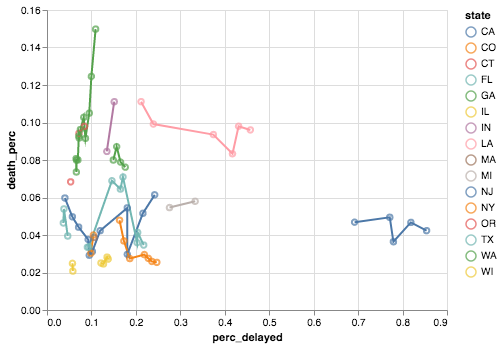

In [230]:
y = "death_perc"
x = "perc_delayed"

h = (
    Chart(ddelayed)
    .mark_line()
    .encode(
        x=A.X(x, title=x),
        y=A.Y(y, title=y),
        color=color,
        tooltip=["perc_delayed_s", "death_perc_s", color, x, y, "date"],
    )
)

(h + h.mark_point()).interactive()

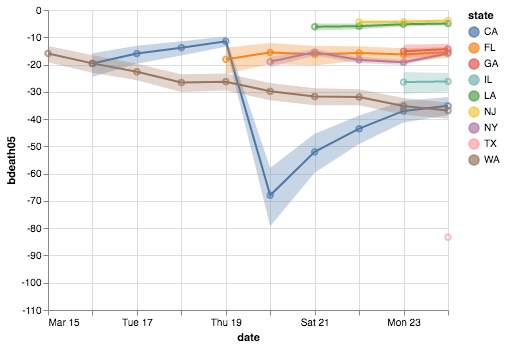

In [77]:
b_delay = ms.extract_arrs(res)['b_death']
b_delay_qs = b_delay.quantile([.05, .5, .95])

['p_delay', 'b_death']


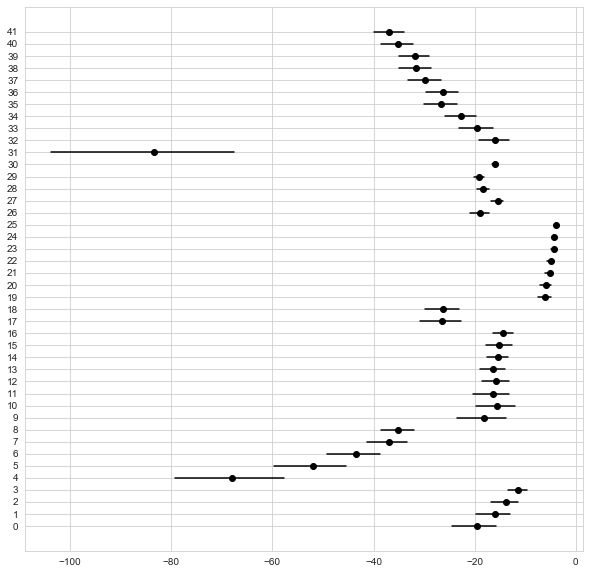

In [81]:
plt.figure(figsize=(10, 10)); ax = plt.gca()
ms.plot_pctiles(b_delay)

In [ ]:
par_p_delay

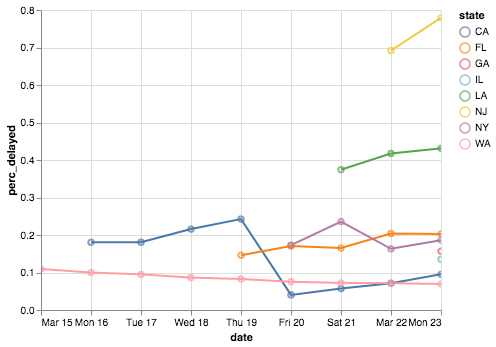

In [184]:
pl(ddelayed.query("prev_perc_delayed > 0"), y="perc_delayed", logy=0)

In [67]:
pdf = ddfs.query("positive > 0").query("n_pct_rows > 3")

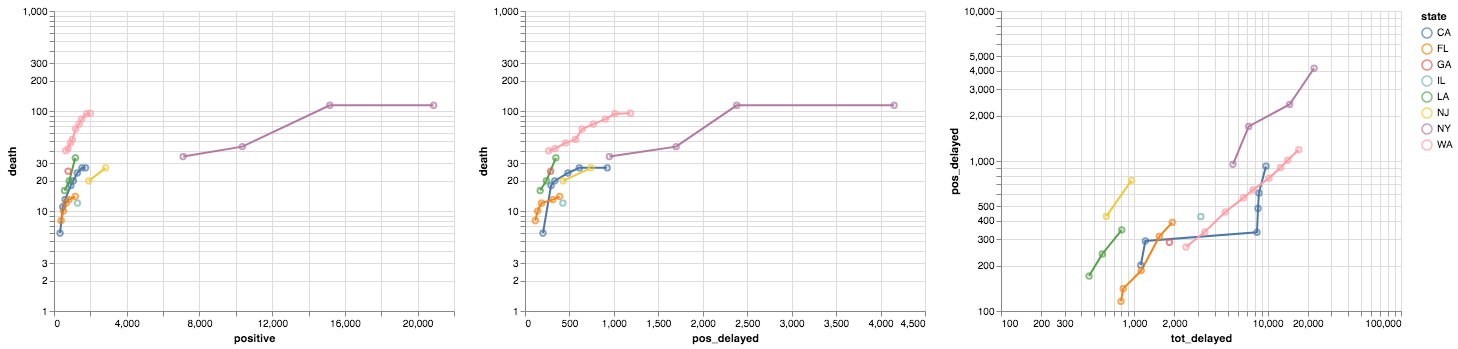

In [119]:
pdf = ddfs.query("positive > 0").query("n_pct_rows > 3").query("tot_delayed > 0")
p1 = pl(pdf, y="death", x="positive", color="state", tt=['perc'])
p2 = pl(pdf.query("~dupe_neg"), y="death", x="pos_delayed")
p3 = pl(pdf.query("~dupe_neg"), y="pos_delayed", x="tot_delayed", logy=1, logx=1)
p1 | p2 | p3

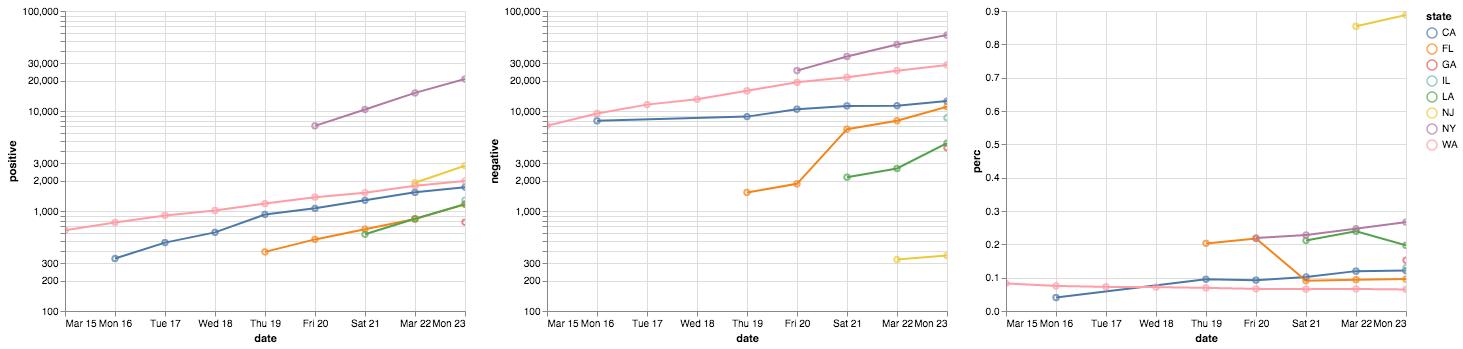

In [120]:
pl(pdf, color="state") | pl(pdf.query("~dupe_neg"), y="negative") |  pl(pdf.query("~dupe_neg"), y="perc", logy=0)

In [34]:
ddfs[:3]

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,perc,dupe_neg,n_pct_rows,tot,pos_delayed,tot_delayed,perc_delayed,prev_perc_delayed
94,2020-03-12,CA,202.0,916.0,NaN,NaN,4.0,1118,2020-03-12T20:00:00Z,0.180680,True,21,1118.0,NaN,NaN,NaN,0.18068
95,2020-03-13,CA,202.0,916.0,NaN,NaN,4.0,1118,2020-03-13T20:00:00Z,0.180680,True,21,1118.0,NaN,NaN,NaN,0.18068
96,2020-03-14,CA,252.0,916.0,NaN,NaN,5.0,1168,2020-03-14T20:00:00Z,0.215753,True,21,1168.0,NaN,NaN,NaN,0.18068


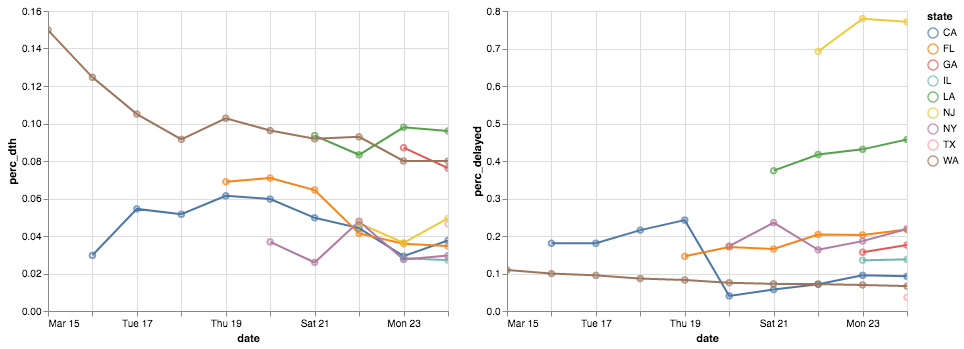

In [38]:
pdf = (
    ddfs.assign(perc_dth=lambda x: x.death / x.pos_delayed)
#     [["state", "perc_dth"]]
#     .drop_duplicates()
#     .sort_values("perc_dth", ascending=True)
)
pl(pdf.query("perc_dth > 0"), y="perc_dth", logy=0) | pl(pdf.query("perc_delayed > 0"), y="perc_delayed", logy=0)

In [54]:
pdf = dfs.query("positive > 0").query("n_pct_rows > 3")

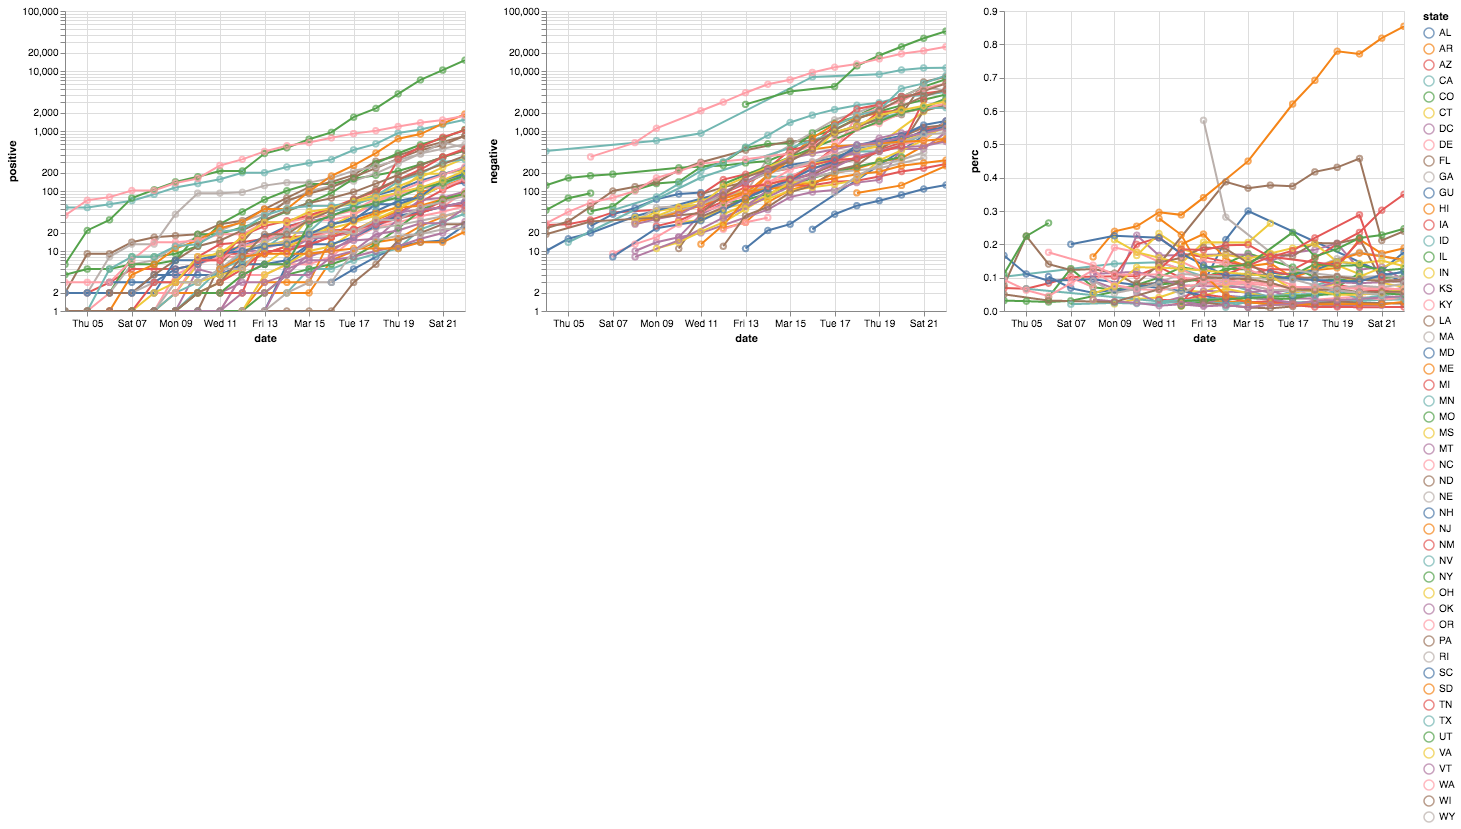

In [55]:
pl(pdf, color="state") | pl(pdf.query("~dupe_neg"), y="negative") |  pl(pdf.query("~dupe_neg"), y="perc", logy=0)

## Secondary data source

In [122]:
@mem.cache
def load2(date='03224'):
    return pd.read_csv('https://coronadatascraper.com/timeseries-tidy.csv')

In [143]:
dfs2 = load2(date='03224')
def _proc(df):
    df = (
        df
        .drop(['lat', 'long', 'url', ], axis=1)
        .query("country == 'USA'")
    )
    return df

dfs2 = _proc(dfs2)

In [155]:
tx = dfs2.assign(null_cty=lambda x: x.county.isnull()).query("date == '2020-03-24'").query("state == 'TX'")

tx.groupby(['type', 'null_cty']).value.sum().unstack().fillna(0).astype(int)

null_cty,False,True
type,,
active,715,704
cases,715,715
deaths,0,11
growthFactor,92,2
tested,0,13235
